In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

In [180]:
df = pd.read_csv('final_project_data.csv', parse_dates = True)

In [181]:
# Specifying the ticker symbol for the British Pound 
ticker_symbol = "GBPUSD=X"

# Downloading the data from Yahoo finance
df2 = yf.download(ticker_symbol, start="1989-03-31", end="2023-12-31")

# Looking at the first 5 and last 5 rows of the dataset
print(df2)

[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2003-12-01  1.723811  1.727205  1.718390  1.718597   1.718597       0
2003-12-02  1.719010  1.732112  1.717298  1.730313   1.730313       0
2003-12-03  1.730493  1.731812  1.725209  1.728101   1.728101       0
2003-12-04  1.727414  1.728997  1.718302  1.720697   1.720697       0
2003-12-05  1.720608  1.733102  1.719809  1.733102   1.733102       0
...              ...       ...       ...       ...        ...     ...
2023-12-25  1.267700  1.274665  1.267700  1.267700   1.267700       0
2023-12-26  1.270487  1.271941  1.268553  1.270487   1.270487       0
2023-12-27  1.272831  1.280115  1.270051  1.272718   1.272718       0
2023-12-28  1.280229  1.282676  1.274015  1.280082   1.280082       0
2023-12-29  1.273545  1.277253  1.270277  1.273399   1.273399       0

[5223 rows x 6 columns]


In [182]:
df2.reset_index(inplace=True)

In [183]:
# Merging and shifting the data
df2['Date'] = pd.to_datetime(df2['Date'])
df['Date'] = pd.to_datetime(df['Date'])
df2['Open_2'] = df2['Open']**-1

df2['NextDayOpen'] = df2['Open_2'].shift(-1)

merged_data = pd.merge(left=df, right=df2, left_on='Date', right_on='Date', how='left')

print(merged_data.tail())

           Date   GT02  GTGBP2YR  UKRPCJYR Index  CPI YOY Index  IP Index  \
9161 2023-12-27  4.244     3.955             NaN            NaN       NaN   
9162 2023-12-28  4.278     3.979             NaN            NaN       NaN   
9163 2023-12-29  4.251     3.955             NaN            NaN       NaN   
9164 2023-12-31    NaN       NaN             NaN            NaN       NaN   
9165 2024-01-18    NaN       NaN             NaN            NaN   102.484   

      UKIPI Index      Open      High       Low     Close  Adj Close  Volume  \
9161          NaN  1.272831  1.280115  1.270051  1.272718   1.272718     0.0   
9162          NaN  1.280229  1.282676  1.274015  1.280082   1.280082     0.0   
9163          NaN  1.273545  1.277253  1.270277  1.273399   1.273399     0.0   
9164          NaN       NaN       NaN       NaN       NaN        NaN     NaN   
9165          NaN       NaN       NaN       NaN       NaN        NaN     NaN   

       Open_2  NextDayOpen  
9161  0.78565      0.78111 

In [184]:
# merged_data datetime index
if not isinstance(merged_data.index, pd.DatetimeIndex):
    merged_data.set_index('Date', inplace=True)

# Filling the NA values with the last non-NA value
# This makes the strategy state contingent
filled_data = merged_data.ffill()

# Pulling out the last value of each month
monthly_data = filled_data.resample('M').last()

# Looking at the first 5 values of the variables
print(monthly_data.head())

             GT02  GTGBP2YR  UKRPCJYR Index  CPI YOY Index  IP Index  \
Date                                                                   
1989-03-31  9.668       NaN             NaN            NaN       NaN   
1989-04-30  9.276       NaN             NaN            NaN   62.0592   
1989-05-31  8.802       NaN             NaN            NaN   62.0424   
1989-06-30  8.042       NaN             NaN            NaN   61.6948   
1989-07-31  7.518       NaN             NaN            NaN   61.6915   

            UKIPI Index  Open  High  Low  Close  Adj Close  Volume  Open_2  \
Date                                                                         
1989-03-31          NaN   NaN   NaN  NaN    NaN        NaN     NaN     NaN   
1989-04-30         74.3   NaN   NaN  NaN    NaN        NaN     NaN     NaN   
1989-05-31         76.2   NaN   NaN  NaN    NaN        NaN     NaN     NaN   
1989-06-30         74.2   NaN   NaN  NaN    NaN        NaN     NaN     NaN   
1989-07-31         74.2   N

### Model Based on Interest Rate Differential

In [185]:
# Calculating the Interest rate differencial
monthly_data['ir_diff'] = monthly_data['GT02'] - monthly_data['GTGBP2YR']

In [186]:
monthly_data.isnull().sum()

GT02                0
GTGBP2YR           34
UKRPCJYR Index    171
CPI YOY Index     163
IP Index            1
UKIPI Index         1
Open              177
High              177
Low               177
Close             177
Adj Close         177
Volume            177
Open_2            177
NextDayOpen       177
ir_diff            34
dtype: int64

Since we have resampled our data to monthly and our strategy is based on monthly changes and we are using the ffill function to fill the NA values with the last non-NA value we dicided to not deal with the NAs in the rest of the variables. Also, please not that our strategy is relying on three variables: ir_diff and the two currency variables and so the NAs are a non-starter in this case

In [187]:
# Splitting the dataset to start from 2004 to 2023
start_date = '2004-01-01'
end_date = '2023-12-01'

# Selecting specific rows from the dataset based on date range
data = monthly_data.loc[start_date:end_date]

# Looking at the first 5 and the last 5 rows of the dataset
print(data.head())
print(data.tail())

             GT02  GTGBP2YR  UKRPCJYR Index  CPI YOY Index  IP Index  \
Date                                                                   
2004-01-31  1.823     4.412             1.3            1.9   92.1722   
2004-02-29  1.645     4.274             1.4            1.9   92.3270   
2004-03-31  1.576     4.416             1.3            1.7   92.8873   
2004-04-30  2.319     4.574             1.1            1.7   92.5325   
2004-05-31  2.536     4.929             1.2            2.3   92.9096   

            UKIPI Index      Open      High       Low     Close  Adj Close  \
Date                                                                         
2004-01-31        101.8  1.816299  1.826284  1.806587  1.825284   1.825284   
2004-02-29        103.1  1.863412  1.869508  1.847712  1.869508   1.869508   
2004-03-31        102.8  1.826584  1.846586  1.825484  1.843386   1.843386   
2004-04-30        102.9  1.773301  1.780088  1.766909  1.778600   1.778600   
2004-05-31        103.4  1.

In [188]:
# Checking for NA values in the newly sliced dataset
data.isnull().sum()

GT02              0
GTGBP2YR          0
UKRPCJYR Index    0
CPI YOY Index     0
IP Index          0
UKIPI Index       0
Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
Open_2            0
NextDayOpen       0
ir_diff           0
dtype: int64

As can be observed above, the variables used in our strategy do not suffer from missing values.  

In [189]:
# Set the filter gain
k = 0.7394736842105263

# set the number of standard deviations
z = 1.4210526315789

# Exponentially wieghted moving average applied to teh fundamental
data.loc[:, "Filter"] = data["ir_diff"].ewm(alpha=k, adjust=False).mean()

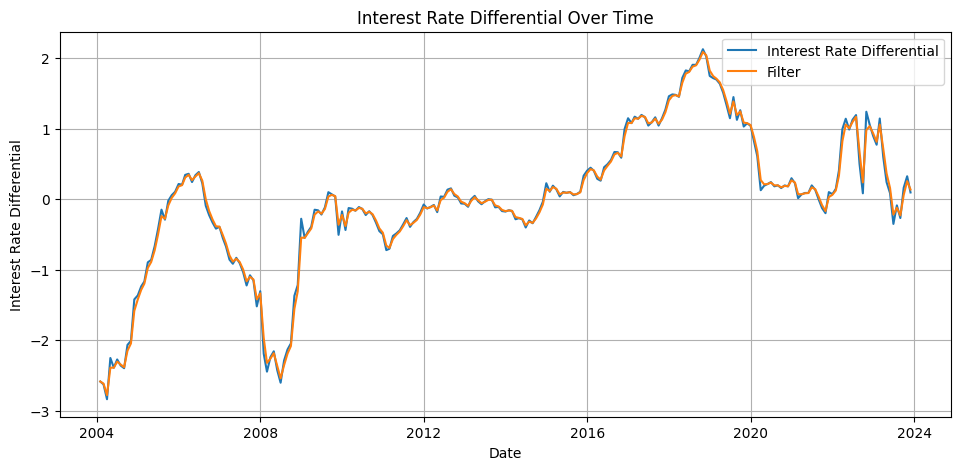

In [190]:
# Plot the interest rate differential ('ir_diff')
plt.figure(figsize=(11.5, 5))  # Adjust the figure size as needed

plt.plot(data['ir_diff'], label='Interest Rate Differential', linestyle='-')
plt.plot(data['Filter'], label='Filter', linestyle='-')

plt.title('Interest Rate Differential Over Time')  # Set the title of the plot
plt.xlabel('Date')  # Set the x-axis label
plt.ylabel('Interest Rate Differential')  # Set the y-axis label
plt.legend()  # Show legend
plt.grid(True)  # Show grid

plt.show()

In [191]:
# Implementing the Filter and signal generation
data.loc[:, "Filter"] = data["ir_diff"].ewm(alpha=k, adjust=False).mean()

# 'Filter Error' 列を追加
data.loc[:, "Filter Error"] = data["ir_diff"] - data["Filter"]

# 'std' 列を追加
data.loc[:, "std"] = data["Filter Error"].ewm(alpha=k, adjust=False).std(bias=False)

# 'Upper' と 'Lower' 列を追加
data.loc[:, "Upper"] = data["Filter"] + z * data["std"]
data.loc[:, "Lower"] = data["Filter"] - z * data["std"]

# 'signal' 列を追加し、前方穴埋め（ffill）を使用してNAを処理
data.loc[:, "signal"] = np.where(data["Filter Error"].abs() > z * data["std"], 1, np.NaN) * np.sign(data["Filter Error"])
data.loc[:, "signal"] = data["signal"].ffill()

In [192]:
# Updated dataset with additional columns
data.head()

,GT02,GTGBP2YR,UKRPCJYR Index,CPI YOY Index,IP Index,UKIPI Index,Open,High,Low,Close,...,Volume,Open_2,NextDayOpen,ir_diff,Filter,Filter Error,std,Upper,Lower,signal
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-31,1.823,4.412,1.3,1.9,92.1722,101.8,1.816299,1.826284,1.806587,1.825284,...,0.0,0.55057,0.54801,-2.589,-2.589000,0.000000,NaN,NaN,NaN,NaN
2004-02-29,1.645,4.274,1.4,1.9,92.3270,103.1,1.863412,1.869508,1.847712,1.869508,...,0.0,0.53665,0.53356,-2.629,-2.618579,-0.010421,0.007369,-2.608107,-2.629050,NaN
2004-03-31,1.576,4.416,1.3,1.7,92.8873,102.8,1.826584,1.846586,1.825484,1.843386,...,0.0,0.54747,0.54259,-2.840,-2.782314,-0.057686,0.034393,-2.733440,-2.831188,-1.0
2004-04-30,2.319,4.574,1.1,1.7,92.5325,102.9,1.773301,1.780088,1.766909,1.778600,...,0.0,0.56392,0.56211,-2.255,-2.392379,0.137379,0.125527,-2.213999,-2.570760,-1.0
2004-05-31,2.536,4.929,1.2,2.3,92.9096,103.4,1.835401,1.837188,1.830396,1.832610,...,0.0,0.54484,0.54567,-2.393,-2.392838,-0.000162,0.088818,-2.266623,-2.519053,-1.0


In [193]:
# Creating the returns column
data.loc[:, 'returns'] = np.log(data.loc[:, 'NextDayOpen']).diff()

# Creating the strategy returns column
data.loc[:, 'strat_returns'] = data.loc[:, 'returns'] * data.loc[:, 'signal'].shift()

# Creating the equity curve column
data.loc[:, 'equity_curve'] = np.exp(data.loc[:, 'strat_returns'].cumsum()) - 1

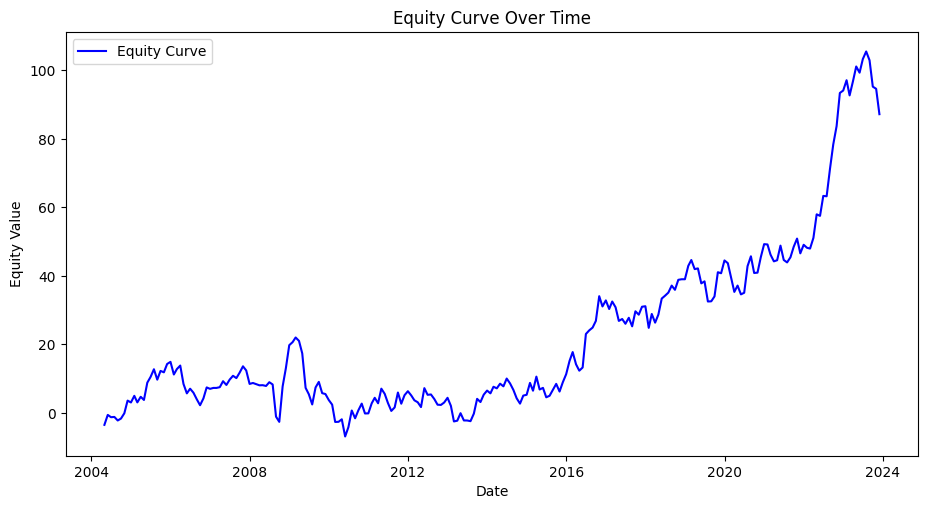

In [194]:
# Plot the equity curve
plt.figure(figsize=(11, 5.5))  # Adjust the figure size as needed
plt.plot(data.index, data['equity_curve']*100, label='Equity Curve', color='blue', linestyle='-')
plt.title('Equity Curve Over Time')  # Set the title of the plot
plt.xlabel('Date')  # Set the x-axis label
plt.ylabel('Equity Value')  # Set the y-axis label
plt.legend()  # Show legend
plt.show()

We enter a long position when the interest rate differential crosses above the filter plus z standard deviations. We enter a short position when the interest rate differential corsses below the filter minus z standard deviations. This is a state contingent strategy. We only exit positions when we receive a signal in the opposite direction of the previous signal.

### Sharpe Ratio

In [195]:
# Dropping NA values
data = data.dropna()

In [196]:
## Add one two equity cirve column so we start at 1
data.loc[:, 'ror'] = data.loc[:, 'equity_curve'] + 1

# calculate number of years where our data is monthly
T = len(data)/12

# calculate CCROR
ccror = np.log(data['ror'].iloc[-1])/T

# calculate AR
AR = data['ror'].iloc[-1]**(1/T)-1

print(ccror*100)
print(AR*100)

3.1893811432900767
3.2407869571858816


In [197]:
risk_free_rate_data = yf.download("^IRX", start="2004-01-31", end="2023-12-31")
risk_free_rate_data['RiskFreeRate'] = risk_free_rate_data['Close'] / 100  # %表示から実数に変換
monthly_risk_free_rate = risk_free_rate_data['RiskFreeRate'].resample('M').mean()

[*********************100%%**********************]  1 of 1 completed


In [198]:
monthly_risk_free_rate.mean()

0.014003767084814798

In [199]:
# convert teh annual rf rate to a monthly one
rf = (1+monthly_risk_free_rate.mean())**(1/12)-1

# strat retruns were log returns and calculate excess returns 
excess = (np.exp(data['strat_returns'])-1)-rf

In [200]:
sharpe = excess.mean()/excess.std()*np.sqrt(12)
print(sharpe)

0.24537944226814706


### Binomial Test

In [201]:
test_frame = data.dropna()

In [202]:
test_frame.head()

,GT02,GTGBP2YR,UKRPCJYR Index,CPI YOY Index,IP Index,UKIPI Index,Open,High,Low,Close,...,Filter,Filter Error,std,Upper,Lower,signal,returns,strat_returns,equity_curve,ror
Date,,,,,,,,,,,,,,,,,,,,,
2004-04-30,2.319,4.574,1.1,1.7,92.5325,102.9,1.773301,1.780088,1.766909,1.778600,...,-2.392379,0.137379,0.125527,-2.213999,-2.570760,-1.0,0.035344,-0.035344,-0.034726,0.965274
2004-05-31,2.536,4.929,1.2,2.3,92.9096,103.4,1.835401,1.837188,1.830396,1.832610,...,-2.392838,-0.000162,0.088818,-2.266623,-2.519053,-1.0,-0.029683,0.029683,-0.005644,0.994356
2004-06-30,2.681,4.957,1.5,3.1,93.5838,101.9,1.808809,1.820698,1.801899,1.820201,...,-2.306439,0.030439,0.045594,-2.241648,-2.371231,-1.0,0.006794,-0.006794,-0.012377,0.987623
2004-07-31,2.681,5.043,1.6,3.3,92.8621,101.7,1.817984,1.824285,1.813007,1.822091,...,-2.347525,-0.014475,0.037492,-2.294246,-2.400804,-1.0,-0.000819,0.000819,-0.011568,0.988432
2004-08-31,2.395,4.795,1.4,3.0,93.5511,101.3,1.795203,1.806489,1.791216,1.802484,...,-2.386329,-0.013671,0.020415,-2.357318,-2.415339,-1.0,0.010601,-0.010601,-0.021990,0.978010


In [203]:
test_frame = test_frame[test_frame.signal != 0][["signal", "NextDayOpen"]].copy()
test_frame['D'] = test_frame["signal"]

In [204]:
test_frame['s_current'] = test_frame["NextDayOpen"]
test_frame['s_future'] = test_frame["NextDayOpen"].shift(-1)


# Get the realized exchange rate
test_frame['R'] = np.where(test_frame['s_future'] >= test_frame['s_current'], 1, -1)

In [205]:
## Sample Covariance
test_frame['W'] = (test_frame['D']-np.mean(test_frame['D']))*(test_frame['R']-np.mean(test_frame['R']))
T_B = np.mean(test_frame['W'])

In [206]:
## Newey-West LRV estimator
dy = test_frame['W'] - np.mean(test_frame['W'])
gamma_0 = sum((dy)**2)/len(test_frame)
gamma_1 = np.mean((dy*dy.shift(-1))[:len(test_frame)-1])
LRV = gamma_0 + 2*(1-1/2)*gamma_1

In [207]:
## Test-statistic
from scipy.stats import norm

statistic = T_B/np.sqrt(LRV/test_frame.shape[0])
print('Test statistic : ', statistic, ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic :  1.702893854024015 , 5 % critical value :  1.64


The null hypothesis for this test is that the expected value of our weighted directional forecasts is zero.

$$ H_0 : E[D_{t,t+h} (s_{t+h}-s_{t})] = 0 $$

while the alternative hypothesis of the one-sided test is that it is positive. 

$$ H_1 : E[D_{t,t+h} (s_{t+h}-s_{t})] > 0 $$

We reject the null hypothesis, and it suggests that our directional forecasts successfully captured the big movements of the realized appreciation or depreciation of exchange rates.

## Heat Map

In [154]:
data_2 = data.copy()

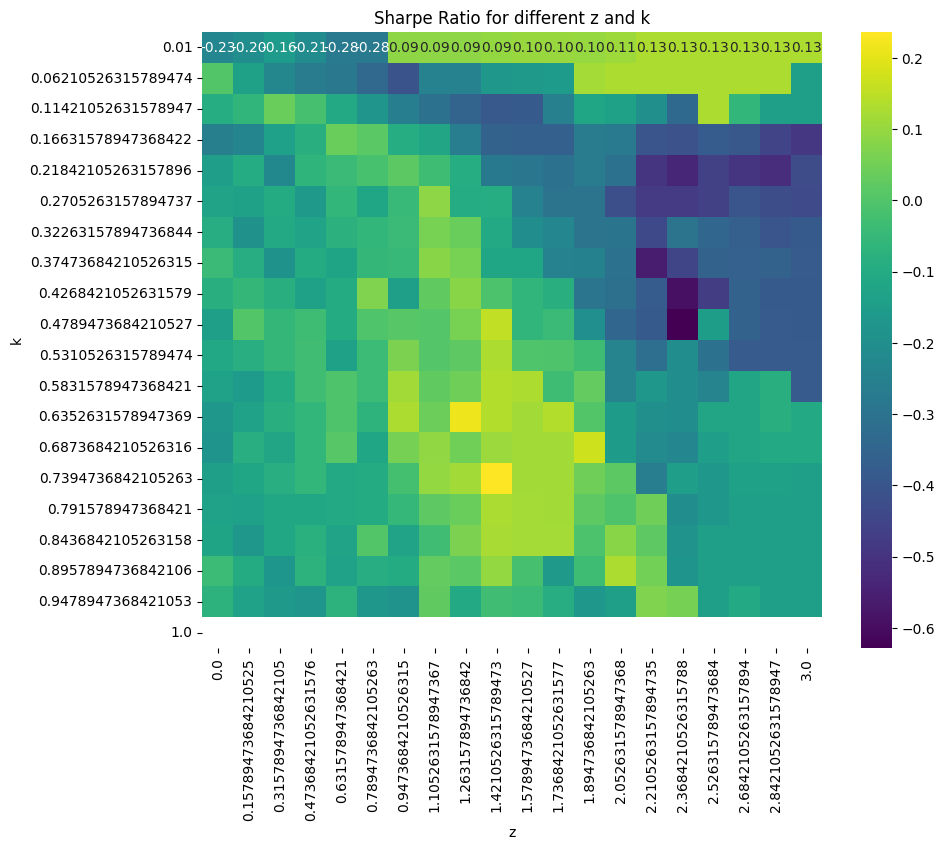

In [155]:
# Creating the Heatmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# defining parameter range
zs = np.linspace(0, 3, 20)  #  z range
ks = np.linspace(0.01, 1, 20)  # k range

# Calculating the Sharpe Ratio
sharpe_ratios = pd.DataFrame(index=ks, columns=zs)

# For loop
for z in zs:
    for k in ks:
        data.loc[:, "Filter"] = data["ir_diff"].ewm(alpha=k, adjust=False).mean()# data['strat_returns'] = data['returns'] * data['signal'].shift()
        # 'Filter' 
        data.loc[:, "Filter"] = data["ir_diff"].ewm(alpha=k, adjust=False).mean()
        # 'Filter Error'
        data.loc[:, "Filter Error"] = data["ir_diff"] - data["Filter"]
        # 'std' 
        data.loc[:, "std"] = data["Filter Error"].ewm(alpha=k, adjust=False).std(bias=False)
        data.loc[:, "Upper"] = data["Filter"] + z * data["std"]
        data.loc[:, "Lower"] = data["Filter"] - z * data["std"]
        data.loc[:, "signal"] = np.where(data["Filter Error"].abs() > z * data["std"], 1, np.NaN) * np.sign(data["Filter Error"])
        data.loc[:, "signal"] = data["signal"].ffill()
        data.loc[:, 'returns'] = np.log(data.loc[:, 'NextDayOpen']).diff()
        data.loc[:, 'strat_returns'] = data.loc[:, 'returns'] * data.loc[:, 'signal'].shift()
        data.loc[:, 'equity_curve'] = np.exp(data.loc[:, 'strat_returns'].cumsum()) - 1
        excess = (np.exp(data['strat_returns'])-1)-rf
        sharpe_ratio = excess.mean()/excess.std()*np.sqrt(12)  
        sharpe_ratios.loc[k, z] = sharpe_ratio

sharpe_ratios = sharpe_ratios.astype(float)
# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sharpe_ratios, annot=True, cmap='viridis', fmt=".2f")
plt.title('Sharpe Ratio for different z and k')
plt.xlabel('z')
plt.ylabel('k')
plt.show()

From the heatmap we choose sharpe ratio of 0.16 with z = 1.421 and k = 0.7395. This point marks the highest sharpe ratio value and it is one of the spots with the brightest color display.